# 第四次计算物理作业

学号： 2021300002018

姓名： 朱向阳

**3.31.** 

研究其他类型的台球桌的行为。一个有趣的可能性是一个正方形台球桌，其中有一个圆形的内墙，可以位于中心位置或略微偏离中心。另一个可能性是一个椭圆形台球桌。

其他边界例程都已完备，便加上了轨迹和椭圆

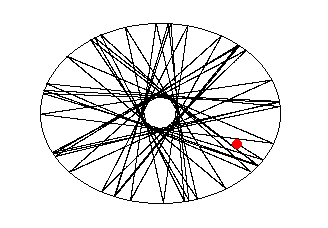

In [38]:
import pygame
from math import pi
import pygame.gfxdraw
import numpy as np
from PIL import Image, ImageDraw

class ball:
    def __init__(self, x0, y0, vx0, vy0, color):
        self.pos = np.array([x0, y0], dtype=float)
        self.v = np.array([vx0, vy0], dtype=float)
        self.dt = 1.0
        self.color = color
    def moveOneStep(self):
        self.pos += self.v*self.dt
    def moveBackOneStep(self):
        self.pos -= self.v*self.dt
    def reflect(self, unit_vector):
        proj_vector = np.dot(self.v, unit_vector)*unit_vector
        self.v -= proj_vector*2
    def display(self, s):
        pygame.draw.circle(s.screen, self.color, self.pos + s.center, 5)

class background:
    def __init__(self, width, height):
        self.width = width
        self.height = height
        self.image = Image.new('RGB', (width, height), 'white')
        self.center = np.array([width/2, height/2], dtype=float)
    def save(self, filename):
        self.image.save(filename)

class ground_screen:
    def __init__(self, width, height):
        self.size = np.array([width, height], dtype=float)
        self.center = np.array([width/2, height/2], dtype=float)
        self.screen = pygame.display.set_mode(self.size)
        pygame.display.set_caption("Balls")
    def display(self):
        self.screen.fill("white")
    def updateCoordinates(self, pos):
        return pos + self.center

class boundary:
    def __init__(self):
        pass
    def isInsideBoundary(self):
        pass
    def normalizeVector(self, vector):
        return vector / np.sqrt(np.dot(vector, vector))
    def draw(self, pict):
        pass

class sinBoundary(boundary):
    def __init__(self, amplitude, frequency):
        super().__init__()
        self.a = amplitude
        self.f = frequency
    def draw(self, p):
        dr = ImageDraw.Draw(p.image)
        x = np.arange(0, p.width)
        y = self.a * np.sin(self.f * x) + p.height/2
        points = np.column_stack((x, y)).flatten().tolist()
        dr.line(points, fill="red")

class squareBoundary(boundary):
    def __init__(self, w):
        super().__init__()
        self.w = w
    def draw(self, p):
        dr = ImageDraw.Draw(p.image)
        dr.rectangle([p.center[0] - self.w/2, p.center[1] - self.w/2, p.center[0] + self.w/2, p.center[1] + self.w/2], outline="black", width=1)
    def display(self, s):
        pygame.draw.line(
                s.screen,
                "black",
                np.array([s.center[0] - self.w/2, s.center[1] - self.w/2]),
                np.array([s.center[0] + self.w/2, s.center[1] - self.w/2]),
                1
                )
        pygame.draw.line(
                s.screen,
                "black",
                np.array([s.center[0] - self.w/2, s.center[1] - self.w/2]),
                np.array([s.center[0] - self.w/2, s.center[1] + self.w/2]),
                1
                )
        pygame.draw.line(
                s.screen,
                "black",
                np.array([s.center[0] + self.w/2, s.center[1] + self.w/2]),
                np.array([s.center[0] + self.w/2, s.center[1] - self.w/2]),
                1
                )
        pygame.draw.line(
                s.screen,
                "black",
                np.array([s.center[0] - self.w/2, s.center[1] + self.w/2]),
                np.array([s.center[0] + self.w/2, s.center[1] + self.w/2]),
                1
                )
    def isInsideBoundary(self, ball):
        return (ball.pos[0]>-self.w/2 and ball.pos[0]<self.w/2 and ball.pos[1]>-self.w/2 and ball.pos[1]<self.w/2)
    def reflectionNormalVector(self, ball):
        rv = np.array([0, 0])
        if ball.pos[0]<-self.w/2:
            rv += np.array([-1, 0])
        if ball.pos[0]>self.w/2:
            rv += np.array([1, 0])
        if ball.pos[1]<-self.w/2:
            rv += np.array([0, -1])
        if ball.pos[1]>self.w/2:
            rv += np.array([0, 1])
        return self.normalizeVector(rv)

class antiSquareBoundary(squareBoundary):
    def isInsideBoundary(self, ball):
        return not (ball.pos[0]>-self.w/2 and ball.pos[0]<self.w/2 and ball.pos[1]>-self.w/2 and ball.pos[1]<self.w/2)
    def reflectionNormalVector(self, ball):
        ball.moveBackOneStep()
        rv = np.array([0, 0])
        if ball.pos[0]<=-self.w/2:
            rv += np.array([1, 0])
        if ball.pos[0]>=self.w/2:
            rv += np.array([-1, 0])
        if ball.pos[1]<=-self.w/2:
            rv += np.array([0, 1])
        if ball.pos[1]>=self.w/2:
            rv += np.array([0, -1])
        ball.moveOneStep()
        return self.normalizeVector(rv)


class circleBoundary(boundary):
    def __init__(self, r):
        super().__init__()
        self.r = r
    def draw(self, p):
        dr = ImageDraw.Draw(p.image)
        dr.ellipse([p.center[0] - self.r, p.center[1] - self.r, p.center[0] + self.r, p.center[1] + self.r], outline="black", width=1)
    def display(self, s):
        pygame.draw.circle(s.screen, "black", s.updateCoordinates(np.array([0,0])), self.r, 1)
    def isInsideBoundary(self, ball):
        return (np.dot(ball.pos, ball.pos) < self.r*self.r)
    def reflectionNormalVector(self, ball):
        return self.normalizeVector(ball.pos)
    

class elipseBoundary(boundary):
    def __init__(self, a, b):
        super().__init__()
        self.a = a
        self.b = b
    def draw(self, p):
        dr = ImageDraw.Draw(p.image)
        dr.ellipse([p.center[0] - self.a, p.center[1] - self.b, p.center[1] + self.a, p.center[1] + self.b], outline="black", width=1)
    def display(self, s):
        center = s.updateCoordinates(np.array([0,0]))
        pygame.draw.ellipse(s.screen, "black", [center[0] - self.a, center[1] - self.b, center[1] + self.a, center[1] + self.b], 1)
    def isInsideBoundary(self, ball):
        return (np.power(ball.pos[0] / self.a, 2) + np.power(ball.pos[1] / self.b, 2) < 1)
    def reflectionNormalVector(self, ball):
        return self.normalizeVector(ball.pos)


In [39]:
pygame.init()
s1 = ground_screen(500, 500)
b1 = ball(0, 20, 0.3, 0.1, "red")
# b2 = ball(0, 60, 0.5, 0.1, "green")
# sb1 = squareBoundary(100)
# cb1 = circleBoundary(100)
# asb2 = antiSquareBoundary(100)
# sinb = sinBoundary(20, 0.1)
eb = elipseBoundary(120 , 90)

done = False
clock = pygame.time.Clock()

bg = background(500, 500)
# sb1.draw(bg)
# cb1.draw(bg)
# sinb.draw(bg)
eb.draw(bg)
bg.save("background1.png")
bg = pygame.image.load("background1.png")
i = 0
while not done:
    clock.tick(240)

    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            done = True

    s1.display()
    # cb1.display(s1)
    #sb1.display(s1)
    s1.screen.blit(bg, (0, 0))

    b1.display(s1)
    pygame.gfxdraw.pixel(bg, int(s1.center[0] + b1.pos[0]), int(s1.center[1] + b1.pos[1]), (0,0,0)) # tails
    # b2.display(s1)
    # eb.display(s1)

    pygame.display.flip()
    b1.moveOneStep()
    # b2.moveOneStep()
    # if not cb1.isInsideBoundary(b1):
    #     rNV = cb1.reflectionNormalVector(b1)
    #     b1.moveBackOneStep()
    #     b1.reflect(rNV)
    # if not cb1.isInsideBoundary(b2):
    #     rNV = cb1.reflectionNormalVector(b2)
    #     b2.moveBackOneStep()
    #     b2.reflect(rNV)
    # if not sb1.isInsideBoundary(b1):
    #     rNV = sb1.reflectionNormalVector(b1)
    #     b1.moveBackOneStep()
    #     b1.reflect(rNV)
    # if not asb2.isInsideBoundary(b2):
    #     rNV = asb2.reflectionNormalVector(b2)
    #     b2.moveBackOneStep()
    #     b2.reflect(rNV)
    if not eb.isInsideBoundary(b1):
        rNV = eb.reflectionNormalVector(b1)
        b1.moveBackOneStep()
        b1.reflect(rNV)


pygame.quit()